Setup
To run this notebook, you'll need (do these in order):

The suitesparse library:

From conda:

conda install suitesparse

On ubuntu/similar linux

apt-get install suitesparse

My version of the PySPQR repository (This is where you need suitesparse)

https://www.github.com/smithb/PySPQR.git

My LSsurf repository

https://www.github.com/smithb/LSsurf.git

My pointCollection repository:

https://www.github.com/smithb/pointCollection.git

For each repository, you'll need to clone the repo (git clone [url to .git file]), then cd to the 

directory that git makes, and type:

python3 setup.py install --user 

Good luck!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from LSsurf.smooth_xytb_fit import smooth_xytb_fit
import pointCollection as pc
%load_ext autoreload
%autoreload 2

# Introduction
The ATL14/15 algorithm works by fitting a time-varying surface to the data.  The form of the model is:
$$
z_m(x, y, t) = z_0(x,y) + \delta z(x, y, t)
$$
Here $z_0$ is a DEM giving the surface height at time $t_0$, and $dz(x,y,t)$ gives the surface-height change between $t_0$ and $t$ at location $x,y$.  The DEM is represented as a high-resolution grid of elevations, while $dz$ is represented as a set of lower-resolution surfaces, one for each quarter-year interval.  The model is constructed so that the $z_0$ surface for time $t_0$ is uniformally equal to zero.

We find the surface by minimizing the quantity:
$$
R = W_{xx0}^2 \int (\nabla^2 z_0)^2 dA + W_{x0} \int (\nabla z_0)^2 dA + W_{xxt}\int (\nabla^2 \frac{\partial\delta z}{\partial  t})^2 dAdt + W_{xt}\int (\nabla \frac{\partial\delta z}{\partial  t})^2 dAdt + W_{tt}\int (\frac{\partial^2 \delta z}{  \partial t^2})^2 dA + \sum (\frac{z_m(x,y,t)-z_i(x,y,t)}{\sigma_i})^2
$$
Here $W_{xx0}$ is the inverse of the expected RMS of the second spatial derivatives of the surface height, $W_{x0}$ is the the inverse of the expected RMS of the first derivatives of the surface height, $W_{xxt}$ is the the inverse of the expected RMS of the second spatial derivatives of the $dz/dt$ field, etc.  The last term is the sum of the error-scaled residuals between the data and the model.  I've put some mathematical description of how this model behaves in the attenuation_curves.ipynb notebook in this repo's directory.

To construct a surface, we need to specify the data values, the model grid resolutions for the DEM and for the height-change surfaces, the dimensions of the grid, and the expected derivative values.  

## Solutions in one dimension (x)
Initially, we will demonstrate the fit on a long, skinny domain, to illustrate how the model works in one dimension.  We will specify identical values for the data for two different time epochs, so that there is no time variation in the solution, and all variation in the solution is in the DEM ($z_0$) field.

In [2]:
# define the domain's width in x, y, and time
W={'x':1.e4,'y':200,'t':2}
# define the grid center:
ctr={'x':0., 'y':0., 't':0.}
# define the grid spacing
spacing={'z0':50, 'dz':50, 'dt':0.25}

In [3]:
# define the data as a sine wave with a wavelength of 2 km and an amplitude of 100m.  
x=np.arange(-W['x']/2, W['x']/2, 100)
lambda_x=2000
amp=100
D=pc.data().from_dict({'x':x, 'y':np.zeros_like(x),'z':-amp*np.cos(2*np.pi*x/lambda_x),\
                       'time':np.zeros_like(x)-0.5, 'sigma':np.zeros_like(x)+1})
# To ensure a time-constant simulation, replicate the data at times -0.5 and 0.5:
data=pc.data().from_list([D, D.copy().assign({'time':np.zeros_like(x)+0.5})])


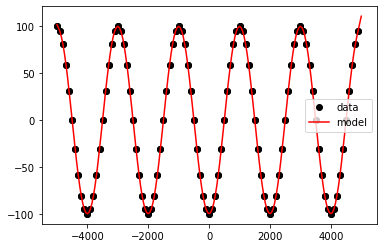

In [4]:
# define the expected statistics of the surface

E_d3zdx2dt=0.0001
E_d2z0dx2=0.06
E_d2zdt2=5000

data_gap_scale=2500
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}

# run the fit
S=smooth_xytb_fit(data=data, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
                 reference_epoch=2, N_subset=None, compute_E=False,
                 max_iterations=1,
                 VERBOSE=False, dzdt_lags=[1])

# plot the results
plt.figure(1)
plt.clf()
plt.plot(data.x, data.z,'ko', label='data')
plt.plot(S['m']['z0'].x, S['m']['z0'].z0[0,:],'r', label='model')
plt.legend();


Reducing the expected expected derivatives results in a smoother surface that does not fit the data as well:

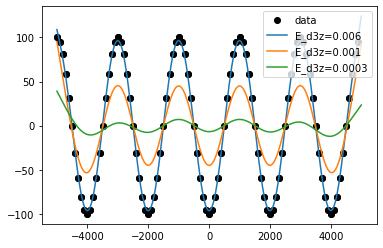

In [5]:
plt.figure(2)
plt.clf()
plt.plot(data.x, data.z,'ko', label='data')
for E_d3z in [0.006, 0.001, 0.0003]:
    E_RMS['d2z0_dx2'] = E_d3z
    # run the fit
    S=smooth_xytb_fit(data=data, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
                     reference_epoch=2, N_subset=None, compute_E=False,
                     max_iterations=1,
                     VERBOSE=False, dzdt_lags=[1])
    
    plt.plot(S['m']['z0'].x, S['m']['z0'].z0[0,:], label=f'E_d3z={E_d3z}')
plt.legend()
E_RMS['d2z0_dx2']= 0.006


If there is a gap in the data, the solution will tend to form a smooth arc over the gap.  The smaller the expected first derivative of the data, the more the solution will flaten out across the gap.  For solutions of this type, the solution will tend to go flat over a distance $data\_gap\_scale$ if $E[RMS(dz/dx)] = E[RMS(d^2z/dx^2)]*data\_gap\_scale$

As you might imagine, we try to set _data\_gap\_scale_ to be about as large as we expect gaps in the data to be, so that large extrapolations don't produce odd values in the solution.

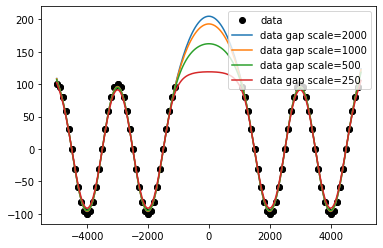

In [110]:
#make a set of data with a gap
data_with_gap=data[np.abs(data.x)>1000]

plt.figure(3)
plt.clf()
plt.plot(data_with_gap.x, data_with_gap.z,'ko', label='data')
# run the solution with different data gap scales
for this_data_gap_scale in [2000, 1000, 500, 250]:
    E_RMS['dz0_dx'] = E_RMS['d2z0_dx2']*this_data_gap_scale
    S=smooth_xytb_fit(data=data_with_gap, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
                     reference_epoch=2, N_subset=None, compute_E=False,
                     max_iterations=1,
                     VERBOSE=False, dzdt_lags=[1])
    
    plt.plot(S['m']['z0'].x, S['m']['z0'].z0[0,:], label=f'data gap scale={this_data_gap_scale}')
plt.legend();

## Solutions in one dimension and time (x, t)

Now let's see what happens when the solution can vary in space and time.  We'll specify a flat surface for t=-0.99 (just after the start of the solution) and a sinusoidal surface for t=0.99 (just before the end).  We will specify that the DEM is for reference epoch 4 (t=0).

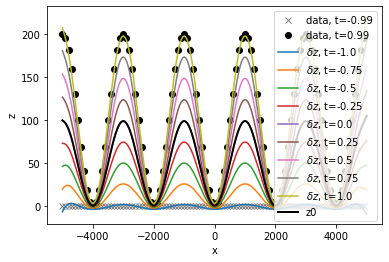

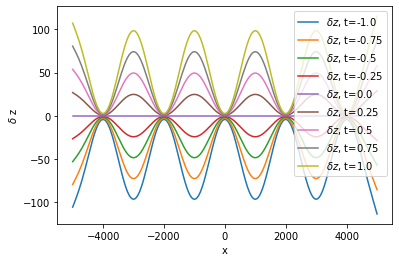

In [183]:
D0=pc.data().from_dict({'x':x, 'y':np.zeros_like(x),'z':np.zeros_like(x),\
                       'time':np.zeros_like(x)-0.99, 'sigma':np.zeros_like(x)+1})
D1=pc.data().from_dict({'x':x, 'y':np.zeros_like(x),'z':amp-amp*np.cos(2*np.pi*x/lambda_x),\
                       'time':np.zeros_like(x)+0.99, 'sigma':np.zeros_like(x)+1})
data_dt=pc.data().from_list([D0, D1])

data_gap_scale=2500
E_RMS['d3z_dx2dt'] = 0.006
E_RMS['d2z_dxdt'] = 0.006*data_gap_scale
E_RMS['d2z0_dx2'] = 0.03
E_RMS['dz0_dx'] = 0.03*data_gap_scale

S=smooth_xytb_fit(data=data_dt, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
                     reference_epoch=4, N_subset=None, compute_E=False,
                     max_iterations=1,
                     VERBOSE=False, dzdt_lags=[1])
plt.figure(4); plt.clf()
plt.plot(D0.x, D0.z,'x', color='gray', label='data, t=-0.99')
plt.plot(D1.x, D1.z,'ko', label='data, t=0.99')

for epoch in range(S['m']['dz'].shape[2]):
    this_time=S['m']['dz'].time[epoch]
    plt.plot(S['m']['dz'].x, S['m']['z0'].z0[2,:]+S['m']['dz'].dz[2,:, epoch], label=f'$\delta z$, t={this_time}')
plt.plot(S['m']['z0'].x, S['m']['z0'].z0[2,:],'k', label='z0', linewidth=2)
plt.xlabel('x')
plt.ylabel('z')
plt.legend();

plt.figure(5); plt.clf()

for epoch in range(S['m']['dz'].shape[2]):
    this_time=S['m']['dz'].time[epoch]
    plt.plot(S['m']['dz'].x, S['m']['dz'].dz[2,:, epoch], label=f'$\delta z$, t={this_time}')
plt.xlabel('x')
plt.ylabel('$\delta$ z')
plt.legend();


The recovered surface matches the data at t=-1 and t=1, and varies smoothly in between. Because the reference epoch is halfway between the two data sets, its value is halfway between flat surface (at $t \approx -1$) and the raised sinusoid (at $t \approx 1$). The $\delta z$ fields smoothly so that at any point, the surface varies approximately linearly from the $t=-1$ to its $t=1$ solution:

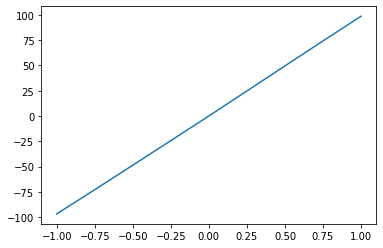

In [184]:
plt.figure(6); 
# find a point close to x=1000 
ii=np.argmin(np.abs(S['m']['dz'].x-1000))
# plot the time series
plt.plot(S['m']['dz'].time, S['m']['dz'].dz[2, ii, :])

If we add another time point at t=-0.25 that is not colinear (in time) with the other time points, we get a smooth time variation at each point:

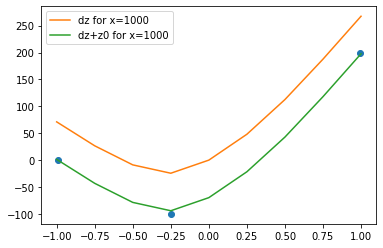

In [185]:
D2 = pc.data().from_dict({'x':x, 'y':np.zeros_like(x),'z':-1*amp+np.zeros_like(x),\
                       'time':np.zeros_like(x)-0.25, 'sigma':np.zeros_like(x)+1})

data_dt2=pc.data().from_list([D0, D1, D2])


S=smooth_xytb_fit(data=data_dt2, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
                     reference_epoch=4, N_subset=None, compute_E=False,
                     max_iterations=1,
                     VERBOSE=False, dzdt_lags=[1])
plt.figure(7); 
# Find the data points closest x=1000
di=np.where(np.abs(data_dt2.x-1000)<2)
plt.plot(data_dt2.time[di], data_dt2.z[di],'o')

# find a model point close to x=1000 
ii=np.argmin(np.abs(S['m']['dz'].x-1000))
# plot the recovered time series
plt.plot(S['m']['dz'].time, S['m']['dz'].dz[2, ii, :], label='dz for x=1000')
plt.plot(S['m']['dz'].time, S['m']['dz'].dz[2, ii, :] + S['m']['z0'].z0[2,ii], label='dz+z0 for x=1000')
plt.legend();

# Editing outliers
Outliers are identified based on the distribution of scaled residuals in the data.  We iterate the solution and at each iteration calculate a robust estimate of the standard deviation of residuals in the data ($\hat{\sigma}$), then remove the outliers that are larger than $3\hat{\sigma}$.  Let's return to the example with two data epochs, add some noise to all the data, and large noise values to a subset of the data.

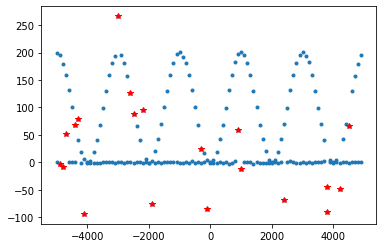

In [217]:
data_dte=pc.data().from_list([D0, D1])
data_dte.z += np.random.randn(data_dte.size)
# introduce about 10% large outliers
outliers = np.argwhere(np.random.rand(data_dte.size) > 0.90).ravel()
data_dte.z[outliers] += (np.random.rand(outliers.size)-0.5)*200

plt.figure(8)
plt.plot(data_dte.x, data_dte.z,'.')
plt.plot(data_dte.x[outliers], data_dte.z[outliers],'r*')


We can see what these outliers do to the solution without editing by running the solution with only one iteration.  Note that we have asked for verbose output from _smooth\_xytb\_fit_, which reports on the robust spread and the outliers from each iteration.  

initial: 199:
starting qr solve for iteration 0 at Fri Jun 26 09:30:16 2020
found 182 in TSE, sigma_hat=6.218, dt=  1


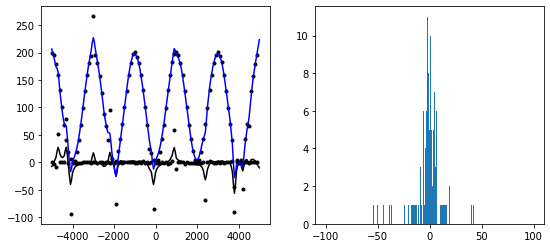

In [218]:
S=smooth_xytb_fit(data=data_dte, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
                     reference_epoch=4, N_subset=None, compute_E=False,
                     max_iterations=1,
                     VERBOSE=True, dzdt_lags=[1])
plt.figure(9, figsize=[9, 4]); plt.clf()
plt.subplot(121)
plt.plot(data_dte.x, data_dte.z,'k.')
plt.plot(S['m']['dz'].x, S['m']['z0'].z0[2,:]+S['m']['dz'].dz[2, :, 0],'k')
plt.plot(S['m']['dz'].x, S['m']['z0'].z0[2,:]+S['m']['dz'].dz[2, :, -1],'b')

plt.subplot(122)
r=S['data'].z-S['data'].z_est
plt.hist(r, np.arange(-100, 100, 0.5));


Running the solution for more iterations eliminates a greater share of the outliers.  The acceptance (or non-acceptance) of the data points is stored in the _three\_sigma\_edit_ field of S['data'].

initial: 199:
starting qr solve for iteration 0 at Fri Jun 26 09:30:26 2020
found 182 in TSE, sigma_hat=6.218, dt=  1
starting qr solve for iteration 1 at Fri Jun 26 09:30:27 2020
found 182 in TSE, sigma_hat=3.208, dt=  1
starting qr solve for iteration 2 at Fri Jun 26 09:30:28 2020
found 184 in TSE, sigma_hat=3.113, dt=  1
starting qr solve for iteration 3 at Fri Jun 26 09:30:28 2020
found 185 in TSE, sigma_hat=3.127, dt=  1
starting qr solve for iteration 4 at Fri Jun 26 09:30:29 2020
found 185 in TSE, sigma_hat=3.128, dt=  1
filtering unchanged, exiting after iteration 4


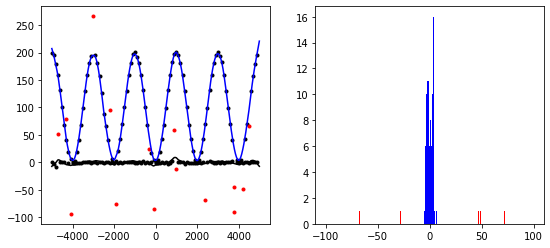

In [219]:
S=smooth_xytb_fit(data=data_dte, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
                     reference_epoch=4, N_subset=None, compute_E=False,
                     max_iterations=10,
                     VERBOSE=True, dzdt_lags=[1])
plt.figure(9, figsize=[9, 4]); plt.clf()
plt.subplot(121)
d_out=S['data']
plt.plot(d_out.x[d_out.three_sigma_edit==1], d_out.z[d_out.three_sigma_edit==1],'k.')
plt.plot(d_out.x[d_out.three_sigma_edit==0], d_out.z[d_out.three_sigma_edit==0],'r.')
plt.plot(S['m']['dz'].x, S['m']['z0'].z0[2,:]+S['m']['dz'].dz[2, :, 0],'k')
plt.plot(S['m']['dz'].x, S['m']['z0'].z0[2,:]+S['m']['dz'].dz[2, :, -1],'b')

plt.subplot(122)
r=d_out.z-d_out.z_est
plt.hist(r, np.arange(-100, 100, 0.5), color='red')
plt.hist(r[d_out.three_sigma_edit==1], np.arange(-100, 100, 0.5), color='blue');


This only works well if the constraints allow a fairly good fit between the data and the model.  If the best misfit allowed by the constraint is large, then the histogram of residuals is broad, and the distinction (in residual space) between outliers and datapoints is not as large.

# Data biases

Let's make a new example, with several cycles of data on the same line.  Each will have a value that is displaced from a trend line to simulate correlated errors (biases) in the data.  

In [278]:
# define simulation parameters
sigma_uncorr=0.1
bias_mag=0.25
#t_vals=np.arange(-0.99, 0.99+0.1, 0.1)
t_vals=np.linspace(-.99, 0.99, 9)
z_vals=0.5*t_vals
# define the bias values
bias_vals=np.random.randn(len(z_vals))*bias_mag

In [279]:
# make dataset
x1=np.arange(-W['x']/2, W['x']/2, 5)
y1=np.zeros_like(x1)
D_list=[]
for cycle in range(len(t_vals)):
    this_z = np.zeros_like(x1)+z_vals[cycle]+bias_vals[cycle] + np.random.rand(x1.size)*sigma_uncorr
    D_list.append(
        pc.data().from_dict({'x':x1,'y':y1,'time':np.zeros_like(x1)+t_vals[cycle], 'cycle':np.zeros_like(x1)+cycle,\
                             'z':this_z, 'sigma':np.zeros_like(x1)+sigma_uncorr,'sigma_corr':np.zeros_like(x1)+bias_mag})
    )
data_biased=pc.data().from_list(D_list)


Note that we have specified a _sigma\_corr_ value that describes the correlated error magnitude.  It doesn't get used until we tell the inversion to solve for errors.

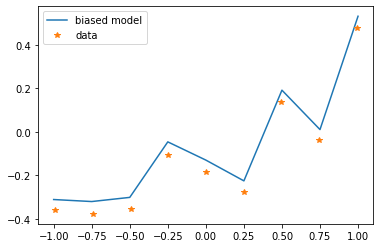

In [291]:
# fit the biased data
Sb=smooth_xytb_fit(data=data_biased, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
                     reference_epoch=4, N_subset=None, compute_E=False,
                     max_iterations=10,
                     VERBOSE=False, dzdt_lags=[1])

# plot the results:
# find a row and a column in the center of the simulation
r0_dz, c0_dz, e0_dz = np.round(np.array(Sb['m']['dz'].shape)/2).astype(int)
r0_z0, c0_z0 = np.round(np.array(Sb['m']['z0'].shape)/2).astype(int)

# plot the model for the center point
plt.figure(10); 
plt.plot(Sb['m']['dz'].time, Sb['m']['dz'].dz[r0_dz, c0_dz, :]+Sb['m']['z0'].z0[r0_z0, c0_z0], label='biased model')
plt.plot(t_vals, bias_vals+z_vals, '*', label='data')
plt.legend()

The result is that the recovered delta-z signal matches the biased data well.  If we fit the data without taking into account the biases, the large number of data points with the same bias exert a strong influence on the model, so the smoothness constraints don't help much to suppress signals related to the biases.

## Estimating data biases

We can tell the inversion that there is a bias parameter using the _blas\_params_ keyword, which takes a list of all parameters over which the bias is correlated: the solution will estimate one bias for each combination of unique values of the parameter in the list, and will set the expected RMS value for each parameter to the median of the correlated error ( _sigma\_corr_ ) values for the data.  If there are four cycles in the data, there will be four bias estimates.  In solving the ATL14/15 problem, we set _bias\_params_ to ['rgt','cycle'], so there is one bias estimated for each rgt and each cycle.

In [282]:
Sbc=smooth_xytb_fit(data=data_biased, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
                     reference_epoch=4, N_subset=None, compute_E=False,
                     max_iterations=10,
                     VERBOSE=False, dzdt_lags=[1], bias_params=['cycle'])

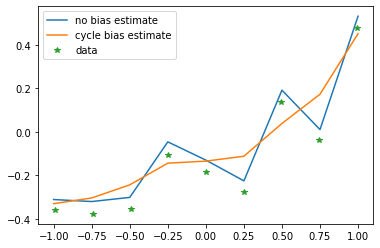

In [290]:
plt.figure(11); 
plt.plot(Sb['m']['dz'].time, Sb['m']['dz'].dz[r0_dz, c0_dz, :]+Sb['m']['z0'].z0[r0_z0, c0_z0], label='no bias estimate')
plt.plot(Sbc['m']['dz'].time, Sbc['m']['dz'].dz[r0_dz, c0_dz, :]+Sbc['m']['z0'].z0[r0_z0, c0_z0], label='cycle bias estimated')
plt.plot(t_vals, bias_vals+z_vals, '*', label='data')
plt.legend()

Letting the inversion take into account the biases in the data results in a much smoother solution, although with larger error estimates, and less ability to recover short-term fluctuations in surface height

# Error estimates

The algorithm can optionally estimate errors for the _z0_ and _dz_ fields, and the biases.  These error estimates depend on:
* the spatial and temporal distribution of the data,
* the error magnitude estimates, and 
* the bias magnitude estimates.  

Let's look at the time-dependent solution from earlier, but remove the central portion to make a data gap. We're making the solution a bit wider in the y direction to allow us a bit of space to play with the model resolution. Note that the solution takes much longer when we calculate errors.

In [333]:
data_dt_gap = data_dt[np.abs(data_dt.x) > 1000]
W1={'x': 10000.0, 'y': 400, 't': 2}
S=smooth_xytb_fit(data=data_dt_gap, ctr=ctr, W=W1, spacing=spacing, E_RMS=E_RMS,
                     reference_epoch=4, N_subset=None, compute_E=True,
                     max_iterations=1, dzdt_lags=[1])

# find a row and a column in the center of the simulation
r0_dz, c0_dz, e0_dz = np.round(np.array(S['m']['dz'].shape)/2).astype(int)
r0_z0, c0_z0 = np.round(np.array(S['m']['z0'].shape)/2).astype(int)


initial: 157:
starting qr solve for iteration 0 at Mon Jun 29 10:59:28 2020
found 158 in TSE, sigma_hat=4.622, dt=  3


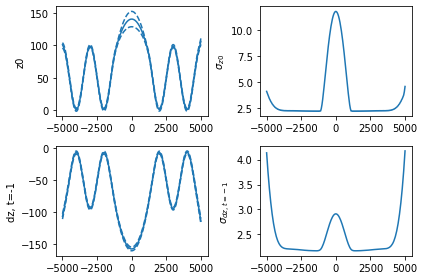

In [347]:
fig=plt.figure(11)
ax=fig.add_subplot(221)
# plot the z0 for the model
hh=plt.plot(S['m']['z0'].x, S['m']['z0'].z0[r0,:], label='z0')
# plot the errors in z0
ax.plot(S['m']['z0'].x, S['m']['z0'].z0[r0_z0,:]+S['E']['z0'].z0[r0_z0,:], '--', color=hh[0].get_color())
ax.plot(S['m']['z0'].x, S['m']['z0'].z0[r0_z0,:]-S['E']['z0'].z0[r0_z0,:], '--', color=hh[0].get_color())
ax.set_ylabel('z0')  
    
ax=fig.add_subplot(222)
ax.plot(S['m']['z0'].x, S['E']['z0'].z0[r0_z0,:])
ax.set_ylabel('$\sigma_{z0}$')
    
ax=fig.add_subplot(223)
hh=ax.plot(S['m']['dz'].x, S['m']['dz'].dz[r0_dz, :, 0])
hh=ax.plot(S['m']['dz'].x, S['m']['dz'].dz[r0_dz, :, 0]- S['E']['dz'].dz[r0_dz, :, 0],'--', color=hh[0].get_color() )
hh=ax.plot(S['m']['dz'].x, S['m']['dz'].dz[r0_dz, :, 0]+ S['E']['dz'].dz[r0_dz, :, 0],'--', color=hh[0].get_color() )
ax.set_ylabel('dz, t=-1')

ax=fig.add_subplot(224)
ax.plot(S['m']['dz'].x, S['E']['dz'].dz[r0_z0,:, 0])
ax.set_ylabel('$\sigma_{dz, t=-1}$')
fig.tight_layout()

We see that the error estimates are small where data are present, then increase across the data gap. Errors are also larger towards the edges of the grid, because farther from the center, fewer datapoints are available to constrain each grid point.

This solution took a long time (and a lot of memory) to calculate, beacause the grids had fine resolution. Since we probably don't care if our error estimates have high or low resolution, we can speed up the calculation substantially by degrading the resolution of the error solution, then interpolating back to the original grid resolution.


initial: 157:
starting qr solve for iteration 0 at Mon Jun 29 12:14:30 2020
found 158 in TSE, sigma_hat=4.873, dt=  0
Starting error calculation
	Error propagation took  9. seconds


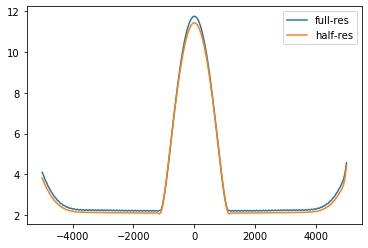

In [341]:
# reduced-resolution fit:
SE = smooth_xytb_fit(data=data_dt_gap, ctr=ctr, W=W1, spacing={'z0':100, 'dz':100, 'dt':0.25}, E_RMS=E_RMS,
                     reference_epoch=4, N_subset=None, compute_E=True,
                     max_iterations=1, dzdt_lags=[1])

# reduced-resolution sigma estimate, interpolated to full resolution
sigma_i = SE['E']['z0'].interp(S['m']['z0'].x, S['m']['z0'].y, field='z0', gridded=True)

plt.figure(12)
plt.plot(S['m']['z0'].x, sigma_0.z0[r0_z0,:], label='full-res')
plt.plot(S['m']['z0'].x,  sigma_i[r0_z0,:], label='half-res')
plt.set_ylabel('$\sigma_{z0}')
plt.legend();


The reduced-resolution sigma estimate is very close to the full-resolution estimate, but takes very much less time to calculate.

## Quantities derived in error propagation

The errors in derived quantities cannot be calculated without an estimate of the covariance structure of the fit model.  Since we are not including the covariance matrix in the output products (because it's too large to even calculate in most cases!) we pre-calculate error estimates for some derived quantities:

* _dz\_dt\_lag\_1_ : dz/dt from epoch to epoch
* _dz\_dt\_lag\_4_ : dz/dt calculated on an annual basis
* _dz\_bar_ : the error in the central 50% of the grid (typically 40x40 km)
* _dz\_dt\_bar\_lag\_1_ , _dz\_dt\_bar\_lag\_4_ , dz/dt averaged over the central portion of the grid, at quarter-annual and annual resolution

For the central-average quantities, we also provide an value for the area of the central estimate (including the effects of projection distortion and the fraction of the central area that is included in the ice mask). 